LIBRERIAS

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import warnings
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pygam
from pygam import s, l, te, f, PoissonGAM
from sklearn.model_selection import KFold
from itertools import product
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.5}'.format)

EXPLORATORY DATA ANALYSIS

In [214]:
freq_o = pd.read_csv("C:/Program1/Proyectos/GLM Auto Insurance/freMTPL2freq.csv")
sev_o  = pd.read_csv("C:/Program1/Proyectos/GLM Auto Insurance/freMTPL2sev.csv")
freq_o.head(), sev_o.head()

(   IDpol  ClaimNb  Exposure  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
 0    1.0        1       0.1         5       0       55          50      B12   
 1    3.0        1      0.77         5       0       55          50      B12   
 2    5.0        1      0.75         6       2       52          50      B12   
 3   10.0        1      0.09         7       0       46          50      B12   
 4   11.0        1      0.84         7       0       46          50      B12   
 
     VehGas Area  Density       Region  
 0  Regular    D     1217  Rhone-Alpes  
 1  Regular    D     1217  Rhone-Alpes  
 2   Diesel    B       54     Picardie  
 3   Diesel    B       76    Aquitaine  
 4   Diesel    B       76    Aquitaine  ,
      IDpol  ClaimAmount
 0     1552        995.2
 1  1010996       1128.1
 2  4024277       1851.1
 3  4007252       1204.0
 4  4046424       1204.0)

In [215]:
print(freq_o['ClaimNb'].value_counts())
print(freq_o['Exposure'].describe())

ClaimNb
0     643953
1      32178
2       1784
3         82
4          7
11         3
5          2
6          1
8          1
16         1
9          1
Name: count, dtype: int64
count   6.7801e+05
mean       0.52875
std        0.36444
min      0.0027322
25%           0.18
50%           0.49
75%           0.99
max           2.01
Name: Exposure, dtype: float64


In [216]:
(freq_o["ClaimNb"] <= 4).mean()

np.float64(0.9999867259182346)

In [217]:
freq_o["ClaimNb"].quantile(.9999)

np.float64(3.0)

In [218]:
(sev_o["ClaimAmount"] <= 100000).mean()

np.float64(0.9984233642403995)

In [219]:
sev_o["ClaimAmount"].quantile(.9984)

np.float64(97498.45926398798)

count   2.6639e+04
mean        2278.5
std     2.9297e+04
min            1.0
25%         686.81
50%         1172.0
75%         1228.1
max     4.0754e+06
Name: ClaimAmount, dtype: float64
      


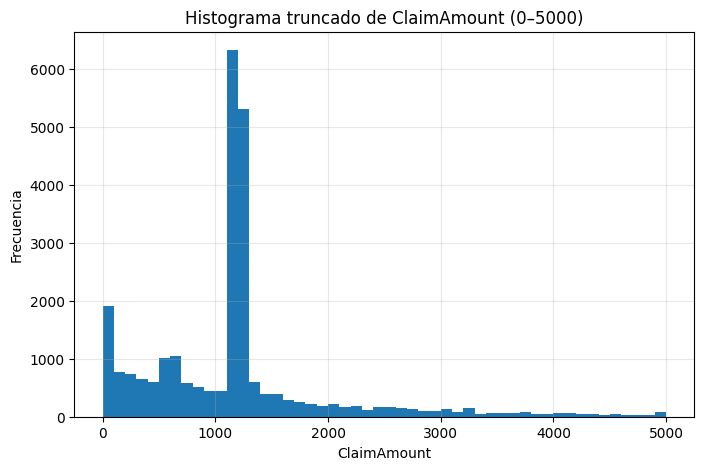

In [220]:
print(f"""{sev_o["ClaimAmount"].describe()}
      """)
plt.figure(figsize=(8,5))
sev_o["ClaimAmount"].hist(bins=50, range=(0,5000))
plt.title("Histograma truncado de ClaimAmount (0–5000)")
plt.xlabel("ClaimAmount")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

Concentracion de datos

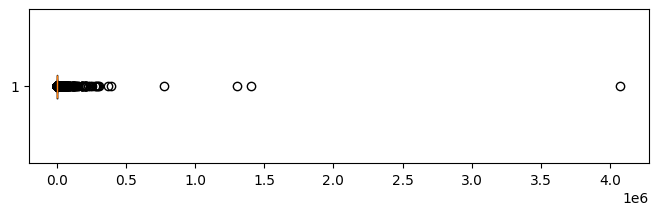

In [221]:
plt.figure(figsize=(8,2))
plt.boxplot(sev_o["ClaimAmount"], vert=False)
plt.show()

Comun en Seguros, colas pesadas, outliers grandes y concentracion de valores pequeños

Límites winsorizados:
1%: 40.0314
99%: 16793.704399999988


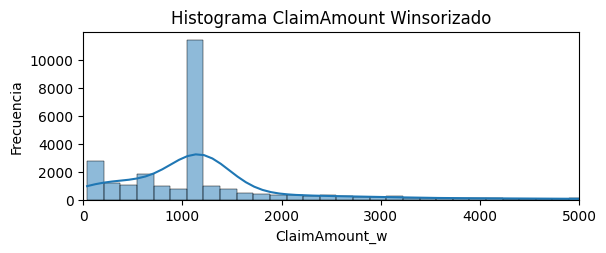

In [222]:
lower = np.percentile(sev_o["ClaimAmount"], 1)
upper = np.percentile(sev_o["ClaimAmount"], 99)

sev_o["ClaimAmount_w"] = sev_o["ClaimAmount"].clip(lower, upper)

print(f"""Límites winsorizados:
1%: {lower}
99%: {upper}""")

plt.subplot(2, 1, 1)
sns.histplot(sev_o["ClaimAmount_w"], kde=True, bins=100)
plt.xlim(0,5000)
plt.title("Histograma ClaimAmount Winsorizado")
plt.xlabel("ClaimAmount_w")
plt.ylabel("Frecuencia")
plt.show()

Winsorizado: elimina los valores mas extremos (percentiles menor a 1 y mayores a 99)

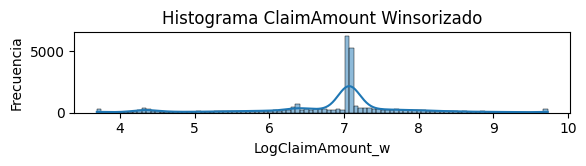

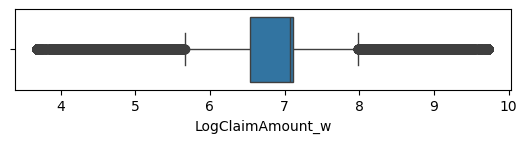

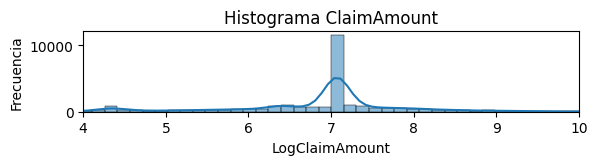

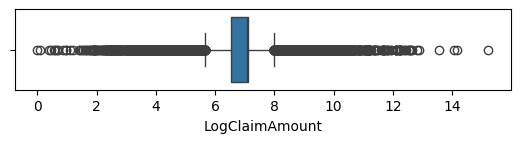

In [223]:
sev_o["LogClaimAmount"] = np.log(sev_o["ClaimAmount"])
sev_o["LogClaimAmount_w"] = np.log(sev_o["ClaimAmount_w"])


plt.subplot(4, 1, 1)
sns.histplot(sev_o["LogClaimAmount_w"], kde=True, bins=100)
plt.title("Histograma ClaimAmount Winsorizado")
plt.xlabel("LogClaimAmount_w")
plt.ylabel("Frecuencia")
plt.show()
plt.subplot(4,1,2)
sns.boxplot(x=sev_o["LogClaimAmount_w"], vert=False)
plt.show()
plt.subplot(4, 1, 3)
sns.histplot(sev_o["LogClaimAmount"], kde=True, bins=100)
plt.xlim(4, 10)
plt.title("Histograma ClaimAmount")
plt.xlabel("LogClaimAmount")
plt.ylabel("Frecuencia")
plt.show()
plt.subplot(4,1,4)
sns.boxplot(x=sev_o["LogClaimAmount"], vert=False)
plt.show()

Data preparation

In [224]:
freq = freq_o.copy()

freq["Exposure"] = freq["Exposure"].clip(upper=1.0)
freq["ClaimNb"] = freq["ClaimNb"].clip(upper=4)
sev = sev_o.copy()
sev["ClaimAmount"] = sev["ClaimAmount"].clip(upper=100000)
sev = sev[sev["ClaimAmount"] > 0]

FRECUENCIAS

              total_claims  total_exposure  frequency
VehPower_bin                                         
(3.999, 5.0]         12932       1.282e+05    0.10087
(5.0, 6.0]            8381      8.2498e+04    0.10159
(6.0, 7.0]            7626       7.792e+04    0.09787
(7.0, 8.0]            1922      2.2674e+04   0.084767
(8.0, 15.0]           5195      4.7065e+04    0.11038


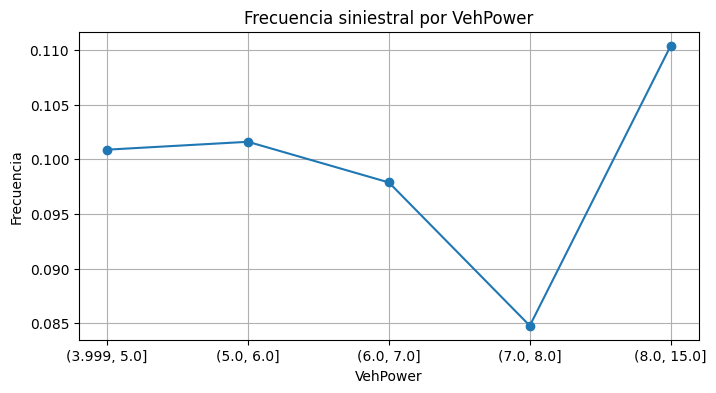

               total_claims  total_exposure  frequency
VehAge_bin                                            
(-0.001, 2.0]         10904      7.9138e+04    0.13778
(2.0, 4.0]             4602      4.9827e+04   0.092359
(4.0, 8.0]             8083       8.145e+04   0.099238
(8.0, 12.0]            7154       7.456e+04   0.095949
(12.0, 100.0]          5313      7.3384e+04     0.0724


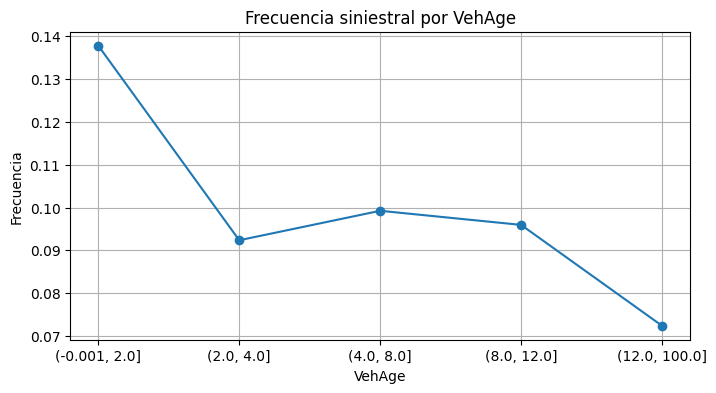

                total_claims  total_exposure  frequency
DrivAge_bin                                            
(17.999, 32.0]          7268      6.0729e+04    0.11968
(32.0, 40.0]            6188      6.8563e+04   0.090253
(40.0, 48.0]            7207       6.999e+04    0.10297
(48.0, 57.0]            7761      7.7306e+04    0.10039
(57.0, 100.0]           7632      8.1772e+04   0.093333


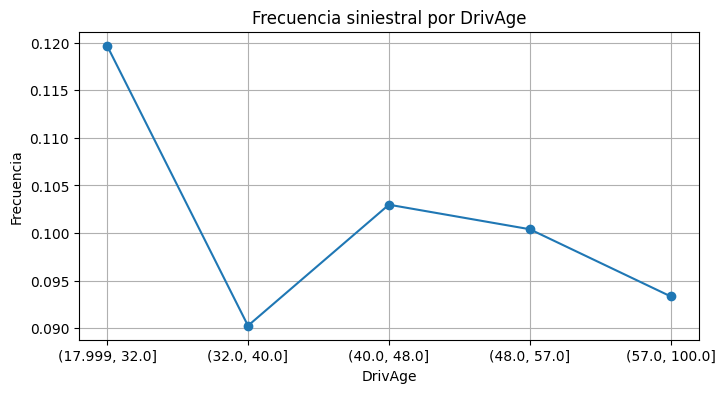

                total_claims  total_exposure  frequency
BonusMalus_bin                                         
(49.999, 53.0]         19063      2.3787e+05    0.08014
(53.0, 72.0]            8213      7.0762e+04    0.11607
(72.0, 230.0]           8780      4.9727e+04    0.17656


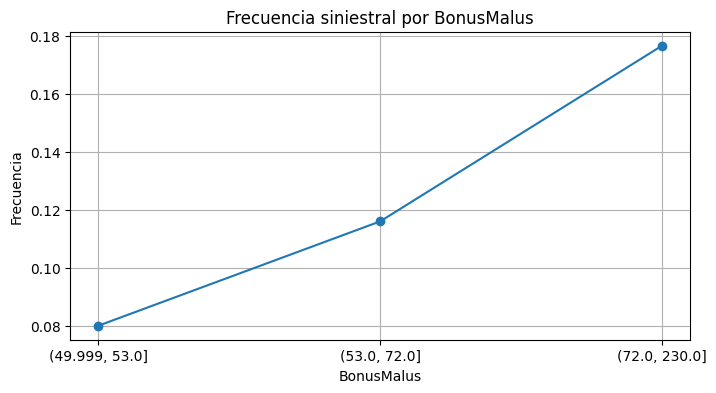

                   total_claims  total_exposure  frequency
Density_bin                                               
(0.999, 67.0]              6746      8.1392e+04   0.082883
(67.0, 214.0]              6743      7.4079e+04   0.091024
(214.0, 716.0]             7091      7.2007e+04   0.098476
(716.0, 2715.0]            7817      6.9457e+04    0.11254
(2715.0, 27000.0]          7659      6.1424e+04    0.12469


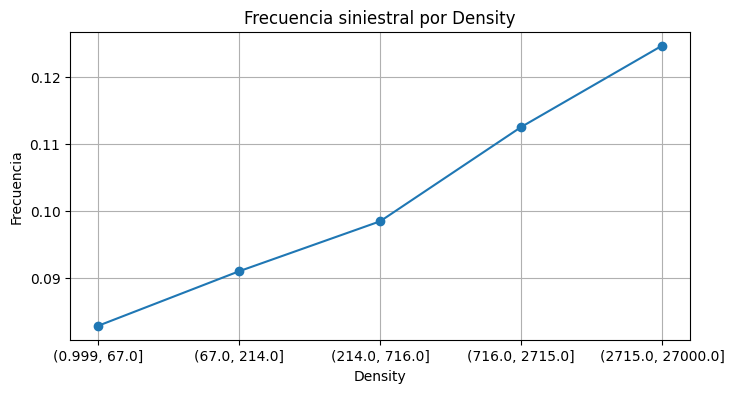

In [225]:
num_cols = [
    col for col in freq.select_dtypes(include=["int", "float"]).columns
    if "IDpol" not in col   # excluye binned
]
result_bins = {}

for col in num_cols:
    #no tiene sentido agrupar
    if col in ["ClaimNb", "Exposure"]:
        continue

    #   columnas categoricas
    freq[col + "_bin"] = pd.qcut(freq[col], q=5, duplicates="drop")

    ntemp = (
        freq.groupby(col + "_bin")
            .agg(
                total_claims=("ClaimNb", "sum"),
                total_exposure=("Exposure", "sum")
            )
    )
    ntemp["frequency"] = ntemp["total_claims"] / ntemp["total_exposure"]
    result_bins[col] = ntemp
    print(ntemp)
    plt.figure(figsize=(8,4))
    plt.plot(ntemp.index.astype(str), ntemp["frequency"], marker="o")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Frecuencia siniestral por {col}")
    plt.grid(True)
    plt.show()

          total_claims  total_exposure  frequency
VehBrand                                         
B1                8639      9.5315e+04   0.090636
B10                858          9489.8   0.090412
B11                721          6883.1    0.10475
B12               8859      6.4802e+04    0.13671
B13                649          6768.0   0.095892
B14                166          2270.5   0.073111
B2                8552      9.4824e+04   0.090188
B3                2818      2.8576e+04   0.098613
B4                1312       1.377e+04   0.095279
B5                2020      1.9984e+04    0.10108
B6                1462      1.5677e+04   0.093255


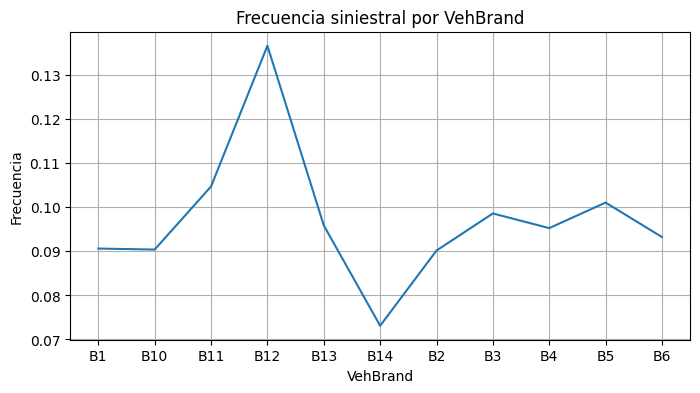

         total_claims  total_exposure  frequency
VehGas                                          
Diesel          16640      1.7059e+05   0.097545
Regular         19416      1.8777e+05     0.1034


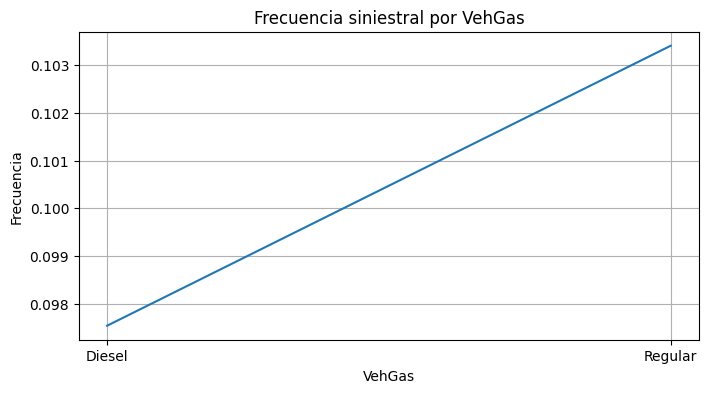

      total_claims  total_exposure  frequency
Area                                         
A             5056      6.1957e+04   0.081605
B             3800      4.3002e+04   0.088368
C             9875       1.044e+05   0.094586
D             8390      7.7088e+04    0.10884
E             7804      6.3786e+04    0.12235
F             1131          8125.4    0.13919


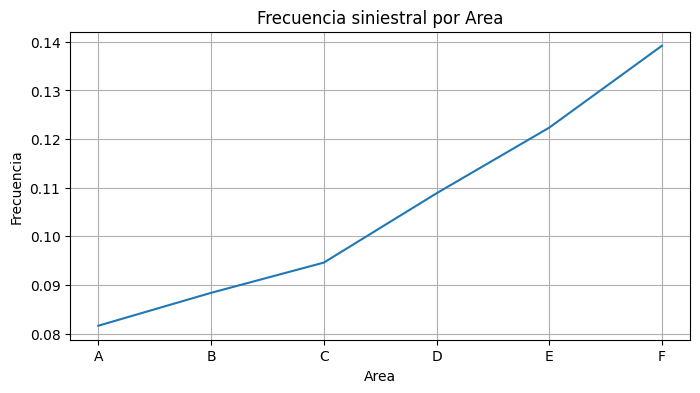

                             total_claims  total_exposure  frequency
Region                                                              
Alsace                                133          1208.6    0.11004
Aquitaine                            1348      1.4316e+04   0.094159
Auvergne                              189          2322.3   0.081386
Basse-Normandie                       633          6652.7    0.09515
Bourgogne                             511          5023.0    0.10173
Bretagne                             2702      2.7753e+04    0.09736
Centre                               9197      1.0271e+05   0.089546
Champagne-Ardenne                     160          1204.3    0.13285
Corse                                 247          1765.9    0.13987
Franche-Comte                          57          563.77     0.1011
Haute-Normandie                       303          3176.9   0.095377
Ile-de-France                        3978      3.0198e+04    0.13173
Languedoc-Roussillon              

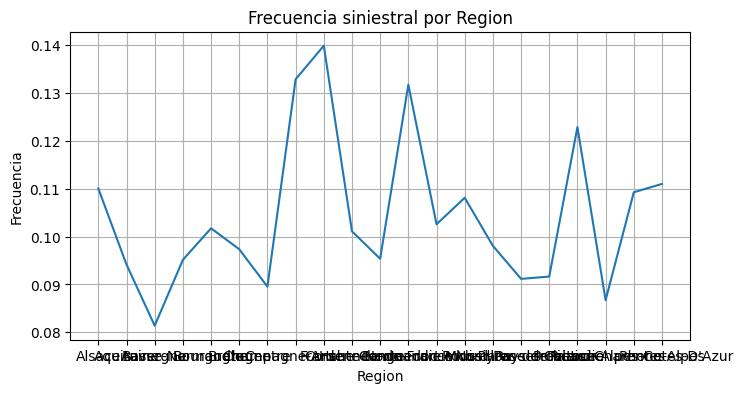

In [226]:
cat_cols = [
    col for col in freq.select_dtypes(include=["object", "category"]).columns
    if "_bin" not in col.lower()   # excluye binned
]
result_c = {}

for col in cat_cols:
    ctemp = (
        freq.groupby(col)
            .agg(
                total_claims=("ClaimNb", "sum"),
                total_exposure=("Exposure", "sum")
            )
    )
    ctemp["frequency"] = ctemp["total_claims"] / ctemp["total_exposure"]
    result_c[col] = ctemp
    print(ctemp)
    plt.figure(figsize=(8,4))
    plt.plot(ctemp.index.astype(str), ctemp["frequency"])
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.title(f"Frecuencia siniestral por {col}")
    plt.grid(True)
    plt.show()


CORRELACIONES

In [227]:
corr_matrix = freq[num_cols].corr(method='pearson')
target_corr = corr_matrix["ClaimNb"].sort_values(ascending=False)
corr_matrix
#target_corr

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
ClaimNb,1.0,0.069744,-0.0039869,-0.022181,0.011312,0.051182,0.010924
Exposure,0.069744,1.0,-0.045398,0.15164,0.17202,-0.18309,-0.071196
VehPower,-0.0039869,-0.045398,1.0,-0.0060015,0.030108,-0.075895,0.042901
VehAge,-0.022181,0.15164,-0.0060015,1.0,-0.059213,0.079923,-0.090428
DrivAge,0.011312,0.17202,0.030108,-0.059213,1.0,-0.47997,-0.0046998
BonusMalus,0.051182,-0.18309,-0.075895,0.079923,-0.47997,1.0,0.077717
Density,0.010924,-0.071196,0.042901,-0.090428,-0.0046998,0.077717,1.0


In [228]:
for col in cat_cols:
    grupos = [group["ClaimNb"].values for _, group in freq.groupby(col)]
    fval, pval = spstats.f_oneway(*grupos) #anova contra freq
    print(f"{col}: p-value = {pval:.5f}")

VehBrand: p-value = 0.00010
VehGas: p-value = 0.00000
Area: p-value = 0.00000
Region: p-value = 0.00000


p < 0.05 -> es relevante para frecuencia de siniestro

In [229]:
for col in cat_cols:
    tabla = pd.crosstab(freq[col], freq["ClaimNb"] > 0) # siniestro sí/no
    chi2, p, dof, exp = spstats.chi2_contingency(tabla)
    print(f"{col}: p-value chi2 = {p:.5f}")


VehBrand: p-value chi2 = 0.00006
VehGas: p-value chi2 = 0.00000
Area: p-value chi2 = 0.00000
Region: p-value chi2 = 0.00000


 p < 0.05 -> variables asociadas con presencia de siniestro

Transformar para GLM

In [230]:
#VehPower
VehPower_bins = [3,6,10,15]
VehPower_labels = ["Low", "Mid", "High"]
freq["VehPower_bins"] = pd.cut(freq["VehPower"], bins=VehPower_bins, labels=VehPower_labels)
#VehAge
VehAge_bins = [-1,5,10,100]
VehAge_labels = ["BrandNew", "Used", "Old"]
freq["VehAge_bins"] = pd.cut(freq["VehAge"], bins=VehAge_bins, labels=VehAge_labels)
#DrivAge
DrivAge_bins = [17,35,55,101]
DrivAge_labels = ["Joven", "Adulto", "AdultoMayor"]
freq["DrivAge_bins"] = pd.cut(freq["DrivAge"], bins=DrivAge_bins, labels=DrivAge_labels)
#BonusMalus
BonusMalus_bins = [-1,50,100,350]
BonusMalus_labels = ["Muy Positivo", "Positivo", "Negativo"]
freq["BonusMalus_bins"] = pd.cut(freq["BonusMalus"], bins=BonusMalus_bins, labels=BonusMalus_labels)



In [231]:
def exp_rel(col):
    total_exp = freq["Exposure"].sum()
    exp_rel = (
        freq.groupby(col)["Exposure"]
            .sum()
            .sort_values()/ total_exp
    )
    return exp_rel

print(exp_rel("Area"))

Area
F   0.022674
B       0.12
A    0.17289
E    0.17799
D    0.21511
C    0.29133
Name: Exposure, dtype: float64


No utilizaremos Region que posee valores menos expuestos, y que se encuentra abarcado en Area

MULTICOLINEALIDAD

In [232]:
X = freq[num_cols].copy()
X = X.assign(const=1)
xvif = pd.DataFrame()
xvif["Variable"] = X.columns
xvif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
xvif

,Variable,VIF
0,ClaimNb,1.012
1,Exposure,1.0904
2,VehPower,1.0119
3,VehAge,1.0478
4,DrivAge,1.3174
5,BonusMalus,1.3518
6,Density,1.0214
7,const,65.064


In [233]:
def cramers_v(x, y):
    tabla = pd.crosstab(x, y)
    chi2 = chi2_contingency(tabla)[0]
    n = tabla.sum().sum()
    r, k = tabla.shape
    return np.sqrt( chi2 / (n * (min(r, k) - 1)) )

def cramers_matrix(df, cols):
    matriz = pd.DataFrame(np.zeros((len(cols), len(cols))), 
                          index=cols, columns=cols)

    for c1 in cols:
        for c2 in cols:
            matriz.loc[c1, c2] = cramers_v(df[c1], df[c2])
    return matriz

matriz_cramer = cramers_matrix(freq, cat_cols)
matriz_cramer

,VehBrand,VehGas,Area,Region
VehBrand,1.0,0.11651,0.073271,0.1297
VehGas,0.11651,1.0,0.13144,0.087238
Area,0.073271,0.13144,1.0,0.31844
Region,0.1297,0.087238,0.31844,1.0


Efectiva colinealidad moderada (>0.3) para region y area

In [234]:
total_exp = freq["Exposure"].sum()
for col in num_cols:
    binned_col = col + "_bins"   # nombre esperado del binning
    if binned_col in freq.columns:          # verificar existencia
        print(f"\n---- {binned_col} ----")
        print(freq.groupby(binned_col)["Exposure"].sum()/total_exp)


---- VehPower_bins ----
VehPower_bins
Low     0.58796
Mid     0.36639
High   0.045651
Name: Exposure, dtype: float64

---- VehAge_bins ----
VehAge_bins
BrandNew   0.42181
Used       0.27619
Old        0.30201
Name: Exposure, dtype: float64

---- DrivAge_bins ----
DrivAge_bins
Joven         0.23849
Adulto        0.49361
AdultoMayor    0.2679
Name: Exposure, dtype: float64

---- BonusMalus_bins ----
BonusMalus_bins
Muy Positivo     0.62829
Positivo         0.36175
Negativo       0.0099641
Name: Exposure, dtype: float64


MODELO GLM

Siendo BonusMalus resultado del riesgo se excluye del GLM (puede absorber riesgo de otras categorias)

In [235]:
freq[cat_cols] = freq[cat_cols].astype("category")
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand",
    "VehGas",
    "Area",
    "Density"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_pois = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.Poisson(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_pois.summary())
print("AIC:", model_pois.aic,"BIC:", model_pois.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677989
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4556e+05
Date:                Wed, 17 Dec 2025   Deviance:                   2.2181e+05
Time:                        22:31:56   Pearson chi2:                 1.75e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.003128
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

No significatividad en parametros, agrupamos
Para vehiculos juntamos todas las no significativas
Density fuera del modelo
Pearson indica distribucion incorrecta y sobredispersion (>1, luego de conseguir los parametros adecuados pasaremos a una BN)
Deviance alta

In [236]:
freq["VehBrand_grp"] = freq["VehBrand"].replace({"B10": "OtherBrand", "B11": "OtherBrand", "B13": "OtherBrand", "B14": "OtherBrand", "B3": "OtherBrand","B5": "OtherBrand","B12": "OtherBrand"})
#agrupamos no significativo y con poca frecuencia


In [237]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_pois = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.Poisson(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_pois.summary())
print("AIC:", model_pois.aic,"BIC:", model_pois.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677996
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4567e+05
Date:                Wed, 17 Dec 2025   Deviance:                   2.2202e+05
Time:                        22:32:03   Pearson chi2:                 1.78e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002815
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [238]:
var_med = model_pois.pearson_chi2 / model_pois.df_resid
print(f"""{var_med}""") #diferencia entre media y varianza (>1) y sobredispersion, usar modelo BN

2.6283043429142694


In [239]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN.summary())
print("AIC:", model_BN.aic,"BIC:", model_BN.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677996
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4516e+05
Date:                Wed, 17 Dec 2025   Deviance:                   1.9384e+05
Time:                        22:32:09   Pearson chi2:                 1.72e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002735
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Probamos sin VehBrand

In [240]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN_NoVehBrand = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN_NoVehBrand.summary())
print("AIC:", model_BN_NoVehBrand.aic,"BIC:", model_BN_NoVehBrand.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   678000
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4525e+05
Date:                Wed, 17 Dec 2025   Deviance:                   1.9403e+05
Time:                        22:32:15   Pearson chi2:                 1.75e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002461
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Empeora sin VehBrand_grp, lo dejamos

Mejoria en la Deviance y loglikelihood, parametros significativos, mejoria en Pearson, mejores AIC y BIC

El intercepto absorbe las categorias base

VehPower: veihuclos mas potentes pueden ser utilizados con mayor cuidado (cocheras, uso en zonas menos peligrosas, etc.)

VehAge: autos antiguos puede percibir menos uso, quedando como autos secundarios, sumado a esto los siniestros pequeños puede llegar a ser ignorados

DrivAge: usuarios experimentados tienen menos siniestros

Areas: ciertas areas pueden ser mas pelgirosas que otras, aumentando la frecuencia de siniestros

VehGas: puede ser proxy, teniendo mas relacion con patrones de uso, tipo de vehiculo, kilometraje, etc (para asegurar si es relevante probaremos el modelo sin la variable y comparamos)

In [241]:
vars_model_nogas = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "Area"
]  
formula = "ClaimNb ~ " + " + ".join(vars_model_nogas)

model_BN = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN.summary())
print("AIC:", model_BN.aic,"BIC:", model_BN.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677997
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4518e+05
Date:                Wed, 17 Dec 2025   Deviance:                   1.9389e+05
Time:                        22:32:21   Pearson chi2:                 1.73e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002672
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Empeora, nos quedamos con el primer modelo 

In [242]:
freq_sev = freq.merge(sev, on = "IDpol", how = "left")

In [243]:
sev = freq_sev[freq_sev["ClaimAmount"]>0].copy()

In [244]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehGas",
    "Area"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)

model_Gamma = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

print(model_Gamma.summary())
print("AIC:", model_Gamma.aic,"BIC:", model_Gamma.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26431
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                          8.6731
Method:                          IRLS   Log-Likelihood:            -2.4837e+05
Date:                Wed, 17 Dec 2025   Deviance:                       36066.
Time:                        22:32:21   Pearson chi2:                 2.29e+05
No. Iterations:                    13   Pseudo R-squ. (CS):          0.0007682
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Sacamos categorias no significativas y agrupamos DrivAge

In [245]:
freq["DrivAge_bins2"] = freq["DrivAge_bins"].replace({"AdultoMayor": "Adulto"})

In [246]:
vars_model2 = [
    "DrivAge_bins"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model2)

model_Gamma = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

print(model_Gamma.summary())
print("AIC:", model_Gamma.aic,"BIC:", model_Gamma.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26441
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          8.7577
Method:                          IRLS   Log-Likelihood:            -2.4857e+05
Date:                Wed, 17 Dec 2025   Deviance:                       36186.
Time:                        22:32:21   Pearson chi2:                 2.32e+05
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0002426
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Es mejor el modelo saturado, probamos otras distribuciones

In [247]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)

model_IG = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.InverseGaussian(sm.families.links.log())
).fit()

print(model_IG.summary())
print("AIC:", model_IG.aic,"BIC:", model_IG.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26427
Model Family:         InverseGaussian   Df Model:                           16
Link Function:                    log   Scale:                       0.0045685
Method:                          IRLS   Log-Likelihood:            -2.3117e+05
Date:                Wed, 17 Dec 2025   Deviance:                       60.198
Time:                        22:32:22   Pearson chi2:                     121.
No. Iterations:                    18   Pseudo R-squ. (CS):           0.001002
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [248]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)

model_Tw = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.Tweedie(var_power=2.5, link=sm.families.links.log())
).fit()

print(model_Tw.summary())
print("AIC:", model_Tw.aic,"BIC:", model_Tw.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26427
Model Family:                 Tweedie   Df Model:                           16
Link Function:                    log   Scale:                         0.19776
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 17 Dec 2025   Deviance:                       1141.9
Time:                        22:32:22   Pearson chi2:                 5.23e+03
No. Iterations:                    16   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

El mejor modelo en lineas generales es el Inversa Gaussiana, que aunque no tiene el menor AIC ni loglikelihood, si tiene el menor deviance, BIC y pearson

Aunque las variables no sean significativas, sacarlas empeora el modelo

Asi los modelos quedan:

In [249]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)

model_BN = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.NegativeBinomial(),
    offset=np.log(freq["Exposure"])
).fit()

print(model_BN.summary())
print("AIC:", model_BN.aic,"BIC:", model_BN.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677996
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4516e+05
Date:                Wed, 17 Dec 2025   Deviance:                   1.9384e+05
Time:                        22:32:27   Pearson chi2:                 1.72e+06
No. Iterations:                     7   Pseudo R-squ. (CS):           0.002735
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [250]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
] 
formula_sev = "ClaimAmount ~ " + " + ".join(vars_model)
model_IG = smf.glm(
    formula=formula_sev,
    data=sev,
    family=sm.families.InverseGaussian(sm.families.links.log())
).fit()

print(model_IG.summary())
print("AIC:", model_IG.aic,"BIC:", model_IG.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26427
Model Family:         InverseGaussian   Df Model:                           16
Link Function:                    log   Scale:                       0.0045685
Method:                          IRLS   Log-Likelihood:            -2.3117e+05
Date:                Wed, 17 Dec 2025   Deviance:                       60.198
Time:                        22:32:28   Pearson chi2:                     121.
No. Iterations:                    18   Pseudo R-squ. (CS):           0.001002
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Text(0, 0.5, 'Pearson resBNiduals')

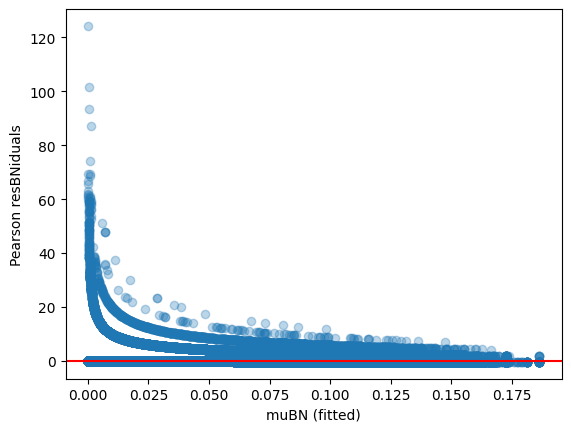

In [251]:
resBN = model_BN.resid_pearson
muBN = model_BN.fittedvalues

plt.scatter(muBN, resBN, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("muBN (fitted)")
plt.ylabel("Pearson resBNiduals")

Text(0, 0.5, 'Pearson resIGiduals')

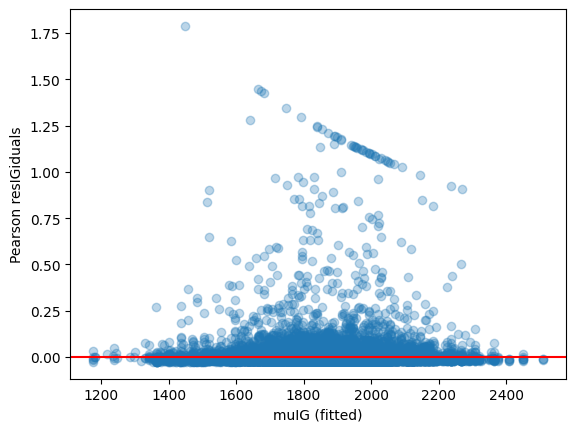

In [252]:
resIG = model_IG.resid_pearson
muIG = model_IG.fittedvalues

plt.scatter(muIG, resIG, alpha=0.3)
plt.axhline(0, color='red')
plt.xlabel("muIG (fitted)")
plt.ylabel("Pearson resIGiduals")

In [253]:
dispersion = sum(resBN**2) / model_BN.df_resid
dispersion

np.float64(2.537114422176054)

In [254]:
dispersion = sum(resIG**2) / model_BN.df_resid
dispersion

np.float64(0.00017807101887426982)

PREDICCIONES Y PRIMAS

In [279]:
freq["pred_freq"] = model_BN.predict(freq)
sev["pred_freq"] = model_BN.predict(freq)
freq["pred_sev"] = model_IG.predict(freq)
sev["pred_sev"] = model_IG.predict(freq)
freq["prima_pura"] = freq["pred_freq"] * freq["pred_sev"]
sev["prima_pura"] = sev["pred_freq"] * sev["pred_sev"]
freq[["pred_freq", "pred_sev","prima_pura"]].head()

,pred_freq,pred_sev,prima_pura
0,0.14162,1935.2,274.07
1,0.14162,1935.2,274.07
2,0.11,1782.2,196.04
3,0.10704,1837.5,196.68
4,0.10704,1837.5,196.68


In [256]:
intercept_BN = np.exp(model_BN.params.filter(like="Intercept"))
intercept_IG = np.exp(model_IG.params.filter(like="Intercept"))
prima_base = int(intercept_BN*intercept_IG)


In [257]:
print(f"""Prima media: {freq["prima_pura"].mean()}
Prima media ponderada: {np.average(freq["prima_pura"], weights=freq["Exposure"])}
Prima Base: {prima_base}""")

Prima media: 199.83990420490613
Prima media ponderada: 191.11882115432084
Prima Base: 211


Supongamos que haya gastos, impuestos, margen, etc.

In [258]:
G_fijos = 50
Impuestos = 0.05
Margen = 0.03
G_var = 0.1

In [259]:
freq["prima_final"] = (freq["prima_pura"] + G_fijos)/(1-Impuestos-Margen-G_var)
print(f""" {freq[["pred_freq", "pred_sev","prima_pura", "prima_final"]]}
Prima Final media: {freq["prima_final"].mean()}
Prima Base: {prima_base}""")
print(freq["prima_final"].describe())


         pred_freq  pred_sev  prima_pura  prima_final
0         0.14162    1935.2      274.07        395.2
1         0.14162    1935.2      274.07        395.2
2            0.11    1782.2      196.04       300.05
3         0.10704    1837.5      196.68       300.83
4         0.10704    1837.5      196.68       300.83
...           ...       ...         ...          ...
678008    0.15516    1925.5      298.76       425.32
678009    0.15516    1925.5      298.76       425.32
678010    0.13159    1888.8      248.56       364.09
678011    0.10936    1919.8      209.95       317.01
678012    0.10557    1955.9      206.48       312.78

[678013 rows x 4 columns]
Prima Final media: 304.6828100059832
Prima Base: 211
count   6.7801e+05
mean        304.68
std         68.744
min         168.37
25%         250.85
50%         296.61
75%         346.66
max         517.31
Name: prima_final, dtype: float64


In [260]:
rel_freq = np.exp(model_BN.params)
rel_sev = np.exp(model_IG.params)
nrel_freq = rel_freq/rel_freq.mean()
nrel_sev = rel_sev/rel_sev.mean()
print(rel_freq)
print(rel_sev)

Intercept                     0.099184
VehPower_bins[T.Mid]           0.97305
VehPower_bins[T.High]          0.91043
VehAge_bins[T.Used]            0.88566
VehAge_bins[T.Old]              0.7138
DrivAge_bins[T.Adulto]           0.898
DrivAge_bins[T.AdultoMayor]    0.82952
VehBrand_grp[T.OtherBrand]      1.1686
VehBrand_grp[T.B2]              1.0019
VehBrand_grp[T.B4]             0.97249
VehBrand_grp[T.B6]              0.9632
VehGas[T.Regular]               1.0762
Area[T.B]                       1.0569
Area[T.C]                       1.1149
Area[T.D]                       1.2643
Area[T.E]                       1.3852
Area[T.F]                       1.4935
dtype: float64
Intercept                      2127.4
VehPower_bins[T.Mid]            1.031
VehPower_bins[T.High]          1.0955
VehAge_bins[T.Used]            0.9495
VehAge_bins[T.Old]            0.95919
DrivAge_bins[T.Adulto]          0.892
DrivAge_bins[T.AdultoMayor]   0.93789
VehBrand_grp[T.OtherBrand]     1.0516
VehBrand_grp[T.B2]

In [261]:
def tabla_relatividades(model, variable):
    """
    Genera tabla de relatividades para una variable categórica en un GLM.
    """
    coef = model.params.filter(like=variable)

    # La categoría base siempre tiene coef = 0
    categorias = ["Base"] + coef.index.tolist()
    valores = [0.0] + coef.values.tolist()

    # Limpiar nombres de categorías
    categorias_limpias = [
        c.replace(variable + "[T.", "").replace("]", "") if c != "Base" else c
        for c in categorias
    ]

    df = pd.DataFrame({
        "Categoria": categorias_limpias,
        "Coef": valores,
    })

    # Relatividad
    df["Relatividad"] = np.exp(df["Coef"])

    # Normalización
    #df["Relatividad_normalizada"] = df["Relatividad"] / df["Relatividad"].mean()

    return df

In [262]:
tablas_freq = {var: tabla_relatividades(model_BN, var) for var in vars_model}

In [263]:
tablas_sev = {var: tabla_relatividades(model_IG, var) for var in vars_model}

COEFIICIENTES MULTIPLICATIVOS

In [264]:
for v, t in tablas_freq.items():
    print("\n=== Frecuencia:", v, "===")
    print(t)

for v, t in tablas_sev.items():
    print("\n=== Severidad:", v, "===")
    print(t)


=== Frecuencia: VehPower_bins ===
  Categoria      Coef  Relatividad
0      Base       0.0          1.0
1       Mid -0.027316      0.97305
2      High -0.093841      0.91043

=== Frecuencia: VehAge_bins ===
  Categoria     Coef  Relatividad
0      Base      0.0          1.0
1      Used -0.12142      0.88566
2       Old -0.33716       0.7138

=== Frecuencia: DrivAge_bins ===
     Categoria     Coef  Relatividad
0         Base      0.0          1.0
1       Adulto -0.10759        0.898
2  AdultoMayor -0.18691      0.82952

=== Frecuencia: VehBrand_grp ===
    Categoria      Coef  Relatividad
0        Base       0.0          1.0
1  OtherBrand   0.15577       1.1686
2          B2 0.0018915       1.0019
3          B4 -0.027894      0.97249
4          B6 -0.037494       0.9632

=== Frecuencia: VehGas ===
  Categoria     Coef  Relatividad
0      Base      0.0          1.0
1   Regular 0.073457       1.0762

=== Frecuencia: Area ===
  Categoria     Coef  Relatividad
0      Base      0.0        

GRILLA TARIFARIA

In [ ]:
categorias = {v: freq[v].unique() for v in vars_model}

grilla = pd.DataFrame(
    list(product(*categorias.values())),
    columns=categorias.keys())

grilla["Pred_freq"] = model_BN.predict(grilla)
grilla["Pred_sev"] = model_IG.predict(grilla)
grilla["Prima_pura"] = grilla["Pred_freq"]*grilla["Pred_sev"]
grilla

,VehPower_bins,VehAge_bins,DrivAge_bins,VehBrand_grp,VehGas,Area,Pred_freq,Pred_sev,Prima_pura
0,Low,BrandNew,Adulto,OtherBrand,Regular,D,0.14162,1935.2,274.07
1,Low,BrandNew,Adulto,OtherBrand,Regular,B,0.11839,1825.9,216.16
2,Low,BrandNew,Adulto,OtherBrand,Regular,E,0.15516,1925.5,298.76
3,Low,BrandNew,Adulto,OtherBrand,Regular,C,0.12488,1798.0,224.54
4,Low,BrandNew,Adulto,OtherBrand,Regular,F,0.16729,1509.7,252.56
...,...,...,...,...,...,...,...,...,...
1615,High,Old,AdultoMayor,B1,Diesel,B,0.056509,1872.3,105.8
1616,High,Old,AdultoMayor,B1,Diesel,E,0.074063,1974.4,146.23
1617,High,Old,AdultoMayor,B1,Diesel,C,0.05961,1843.7,109.9
1618,High,Old,AdultoMayor,B1,Diesel,F,0.079853,1548.0,123.62


ONE PLOTS

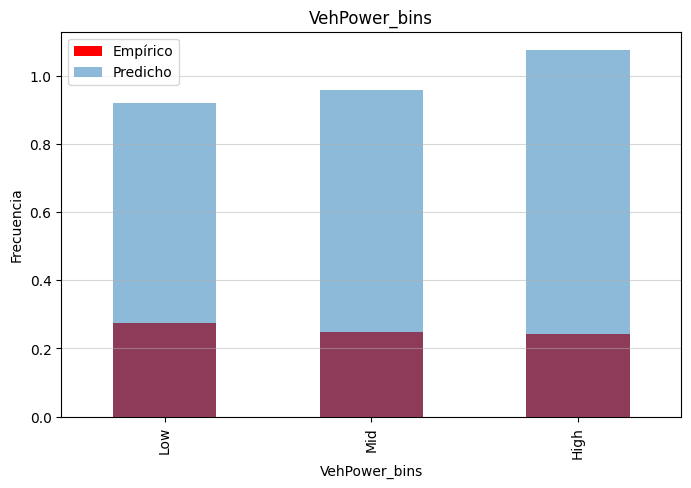

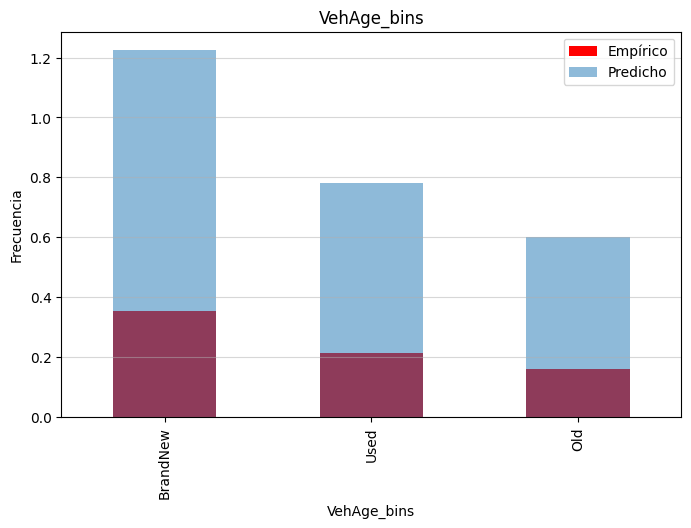

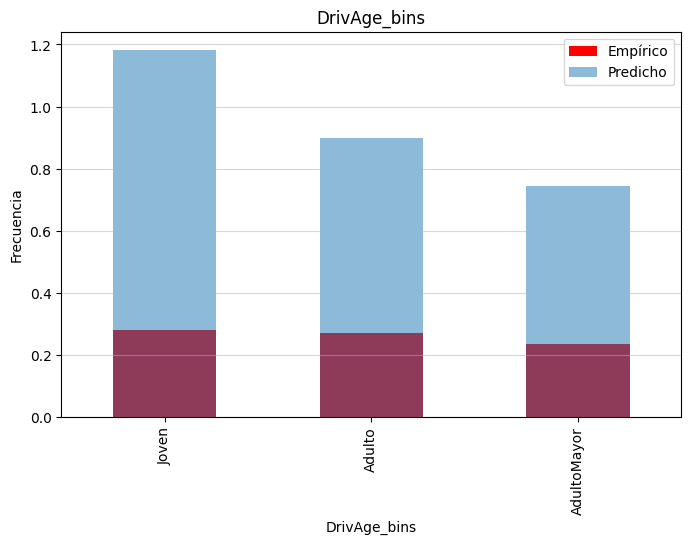

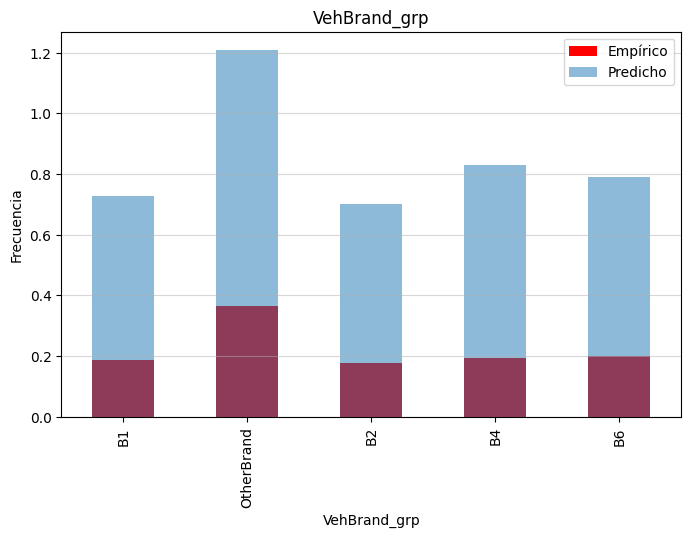

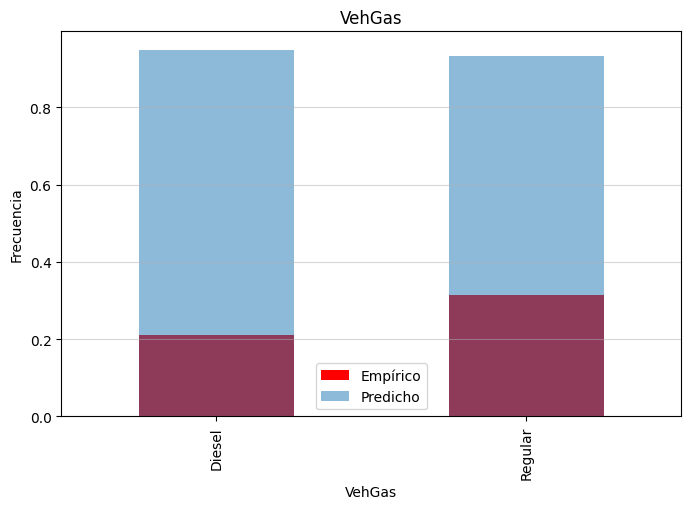

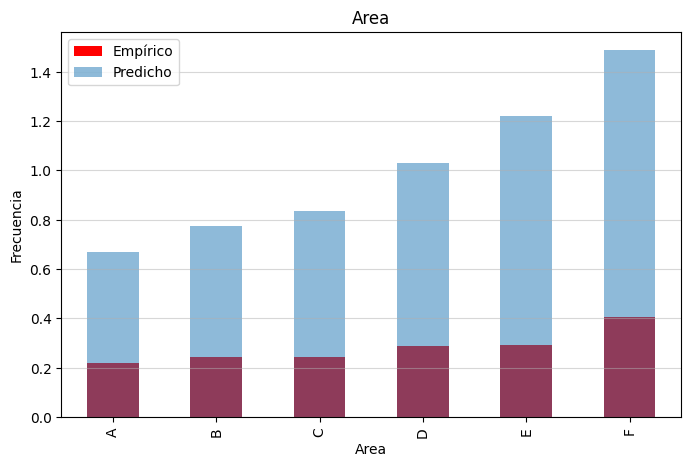

In [190]:
for var in vars_model:
    if "Exposure" is None:
        freq_use = freq.copy()
        freq_use["emp"] = freq_use["ClaimNb"]
        freq_use["pred"] = freq_use["pred_freq"]
    else:
        freq_use = freq.copy()
        freq_use["emp"] = freq_use["ClaimNb"] / freq_use["Exposure"]
        freq_use["pred"] = freq_use["pred_freq"] / freq_use["Exposure"]

    tab = freq_use.groupby(var).agg({"emp":"mean", "pred":"mean"})

    plt.figure(figsize=(8,5))
    tab["emp"].plot(kind="bar", alpha=1, label="Empírico", color="red")
    tab["pred"].plot(kind="bar", alpha=0.5, label="Predicho")
    plt.title(f"{var}")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.grid(axis="y", alpha=.5)
    plt.show()

Sobrestima cantidad de siniestros por categoria (ponderados por exposicion)

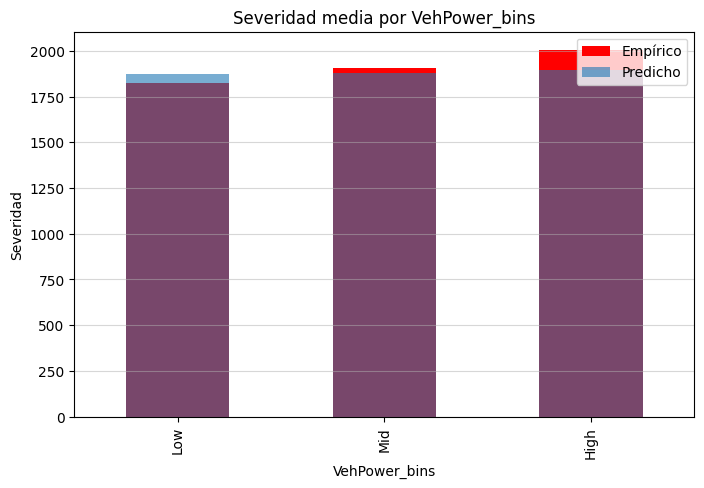

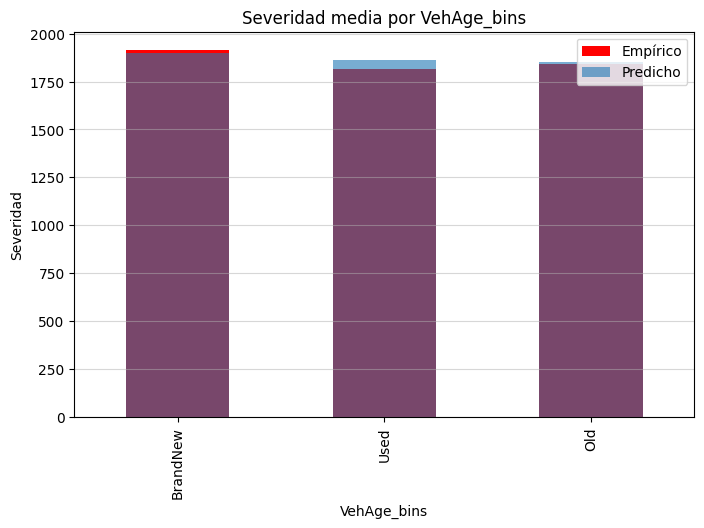

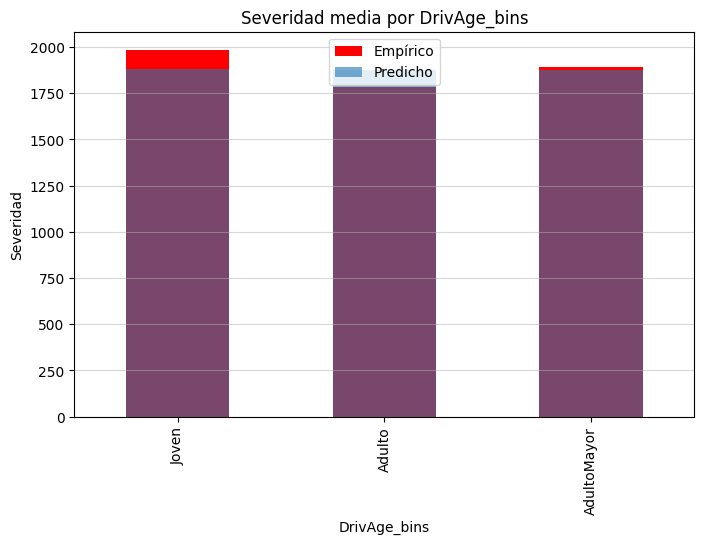

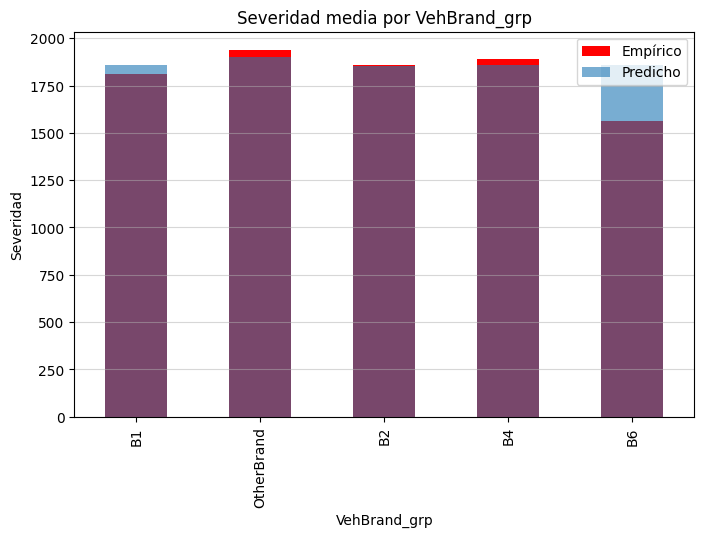

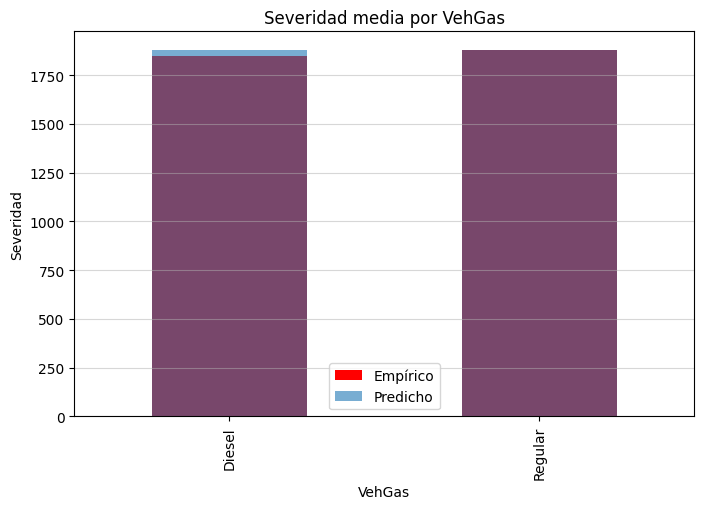

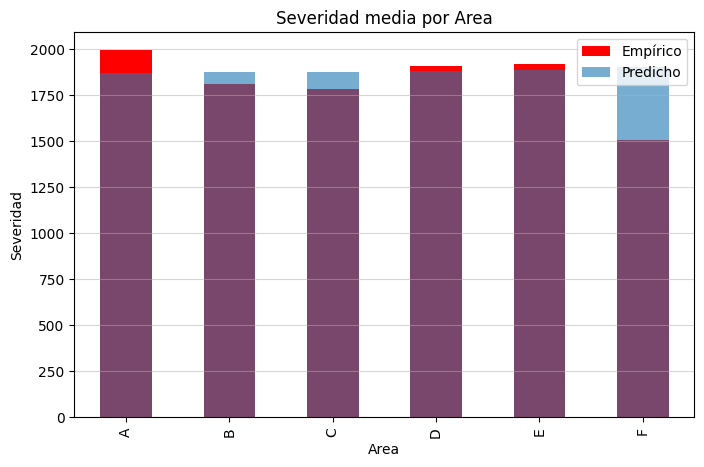

In [191]:
freq_sev = freq_sev.copy()
freq_sev["emp"]  = freq_sev["ClaimAmount"]
freq_sev["pred"] = freq["pred_sev"]

for var in vars_model:
    tab = freq_sev.groupby(var).agg(
        emp=("emp", "mean"),
        pred=("pred", "mean")
    )

    plt.figure(figsize=(8, 5))
    tab["emp"].plot(kind="bar", label="Empírico", alpha=1, color="red")
    tab["pred"].plot(kind="bar", label="Predicho", alpha=0.6)
    plt.title(f"Severidad media por {var}")
    plt.ylabel("Severidad")
    plt.legend()
    plt.grid(axis="y", alpha=0.5)
    plt.show()


Estimacion correcta

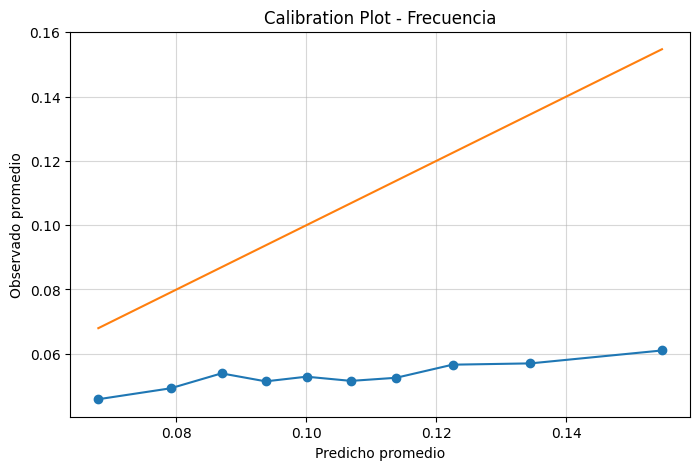

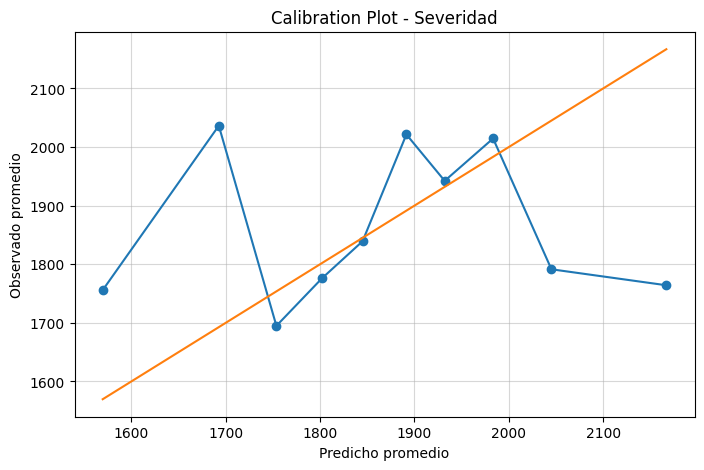

In [192]:
# Crear bins por percentiles de predicción
freq["bin_f"] = pd.qcut(freq["pred_freq"], 10, duplicates="drop")
# Agrupar por bin
cal = freq.groupby("bin_f").agg(
    obs = ("ClaimNb", "mean"),
    pred = ("pred_freq", "mean")
).reset_index()

# Graficar
plt.figure(figsize=(8,5))
plt.plot(cal["pred"], cal["obs"], marker="o")
plt.plot([cal["pred"].min(), cal["pred"].max()],
         [cal["pred"].min(), cal["pred"].max()])
plt.title("Calibration Plot - Frecuencia")
plt.xlabel("Predicho promedio")
plt.ylabel("Observado promedio")
plt.grid(alpha=.5)
plt.show()

sev["bin_s"] = pd.qcut(sev["pred_sev"], 10, duplicates="drop")
# Agrupar por bin
cal = sev.groupby("bin_s").agg(
    obs = ("ClaimAmount", "mean"),
    pred = ("pred_sev", "mean")
).reset_index()

plt.figure(figsize=(8,5))
plt.plot(cal["pred"], cal["obs"], marker="o")
plt.plot([cal["pred"].min(), cal["pred"].max()],
         [cal["pred"].min(), cal["pred"].max()])
plt.title("Calibration Plot - Severidad")
plt.xlabel("Predicho promedio")
plt.ylabel("Observado promedio")
plt.grid(alpha=.5)
plt.show()

Modelo subestima frecuencia global, severidad bien ajustada

In [ ]:
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=123)

loglik_list = []
deviance_list = []

for train_idx, test_idx in kf.split(freq):
    train = freq.iloc[train_idx]
    test  = freq.iloc[test_idx]

    # Ajustar modelo con OFFSET !!
    model = smf.glm(
        formula=formula,
        data=train,
        family=sm.families.NegativeBinomial(),
        offset=np.log(train["Exposure"])
    ).fit()

    # Predicciones out-of-sample con OFFSET
    mu = model.predict(test, offset=np.log(test["Exposure"]))

    # Log-likelihood OOS
    loglik = np.sum(model.family.loglike(test["ClaimNb"], mu))
    loglik_list.append(loglik)

    # Deviance OOS
    dev = model.family.deviance(test["ClaimNb"], mu)
    deviance_list.append(dev)

print("LogLik promedio:", np.mean(loglik_list))
print("Deviance promedio:", np.mean(deviance_list))
print("Desv. LogLik:", np.std(loglik_list))
print("Desv. Deviance:", np.std(deviance_list))


LogLik promedio: -29036.020997078012
Deviance promedio: 38776.32923329693
Desv. LogLik: 212.96855169747118
Desv. Deviance: 275.99465584811827


In [ ]:
# ============================
# CONFIGURACIÓN
# ============================
K = 5  # número de folds
kf = KFold(n_splits=K, shuffle=True, random_state=123)

formula = formula_sev   # tu fórmula
family = sm.families.InverseGaussian(sm.families.links.log())

# Para guardar resultados
metrics = {
    "fold": [],
    "Deviance": []
}

# ============================
# K-FOLD VALIDATION
# ============================
for fold, (train_idx, test_idx) in enumerate(kf.split(sev)):
    print(f"Fold {fold + 1}/{K}")

    train_sev = sev.iloc[train_idx]
    test_sev = sev.iloc[test_idx]
    
    # Ajustar el modelo en el fold
    model = smf.glm(
        formula=formula,
        data=train_sev,
        family=family,
        sev_weights=train_sev["Exposure"]  # muy típico en severidad
    ).fit()

    # Predicciones
    y_true = test_sev["ClaimAmount"]
    y_pred = model.predict(test_sev)

    # ======================
    # MÉTRICAS
    # ======================
    # Gamma deviance para severidad
    dev = family.deviance(y_true, y_pred)

    # Guardar
    metrics["fold"].append(fold + 1)
    metrics["Deviance"].append(dev)

# ============================
# RESULTADOS
# ============================
results = pd.DataFrame(metrics)
print(results)
print("\n===== PROMEDIOS =====")
print(results.mean())


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
   fold  Deviance
0     1    12.307
1     2    12.836
2     3    12.339
3     4    11.555
4     5    11.364

===== PROMEDIOS =====
fold         3.0
Deviance   12.08
dtype: float64


In [ ]:
print(linear_reset(model_BN, power=0.5, use_f=True))

<F test: F=1691.8088873771221, p=0.0, df_denom=6.78e+05, df_num=2>


In [ ]:
print(linear_reset(model_IG, power=3, use_f=True))

<F test: F=1.506689658101835, p=0.22166151672649625, df_denom=2.64e+04, df_num=2>


OTRAS OBSERVACIONES

Quasi Poisson

In [198]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula = "ClaimNb ~ " + " + ".join(vars_model)
model_QP = smf.glm(
    formula=formula,
    data=freq,
    family=sm.families.Poisson(),
).fit(cov_type='HC0')
print(model_QP.summary())
print("AIC:", model_QP.aic,"BIC:", model_QP.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               678013
Model:                            GLM   Df Residuals:                   677996
Model Family:                 Poisson   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.4296e+05
Date:                Wed, 17 Dec 2025   Deviance:                   2.1661e+05
Time:                        22:01:33   Pearson chi2:                 7.21e+05
No. Iterations:                     7   Pseudo R-squ. (CS):          0.0009386
Covariance Type:                  HC0                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Resultados muy parecidos a BN

ZERO INFLATED:

In [199]:
y, X = patsy.dmatrices(formula, freq, return_type='dataframe')
# Para la inflación podés usar las mismas variables o un subconjunto
Z = X.copy()   # lo más simple
X["offset"] = np.log(freq["Exposure"])

In [200]:
# Ajuste
model_ZIP = sm.ZeroInflatedPoisson(
    endog=y,
    exog=X,
    exog_infl=Z,
    offset=X["offset"],
    inflation='logit' #como se producen los 0, probabilidad
).fit(maxiter=10)

print(model_ZIP.summary())
print("AIC:", model_ZIP.aic,"BIC:", model_ZIP.bic)
#inflation: logit para simetria, probit para normal estandar (aptos en sm.)
#cloglog para asimetria (mucha o poca probabilidad de 0), cauchit (colas pesadas). No se encuentran en sm.
#inflate_*: cuanto aporta el parametro a la produccion de 0, bajo el tipo de inflacion

         Current function value: 0.208003
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:                 ClaimNb   No. Observations:               678013
Model:             ZeroInflatedPoisson   Df Residuals:                   677995
Method:                            MLE   Df Model:                           17
Date:                 Wed, 17 Dec 2025   Pseudo R-squ.:                 0.03479
Time:                         22:02:20   Log-Likelihood:            -1.4103e+05
converged:                       False   LL-Null:                   -1.4611e+05
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
inflate_Intercept 

Leve diferencia entre LL y LL-null, los predictores agregan poco valor; p value de LLR indica que no hay evidencia de mejoria en el modelo con covariables

In [201]:
# Ajuste
model_ZIGP = sm.ZeroInflatedGeneralizedPoisson(
    endog=y,
    exog=X,
    exog_infl=Z,
    offset=X["offset"],
    inflation='logit'
).fit(maxiter=10)

print(model_ZIGP.summary())
print("AIC:", model_ZIGP.aic,"BIC:", model_ZIGP.bic)
#en ambos casos, probit no converge y por tanto no lo utilizaremos

         Current function value: 0.207611
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
                    ZeroInflatedGeneralizedPoisson Regression Results                     
Dep. Variable:                            ClaimNb   No. Observations:               678013
Model:             ZeroInflatedGeneralizedPoisson   Df Residuals:                   677995
Method:                                       MLE   Df Model:                           17
Date:                            Wed, 17 Dec 2025   Pseudo R-squ.:                 0.03632
Time:                                    22:12:45   Log-Likelihood:            -1.4076e+05
converged:                                  False   LL-Null:                   -1.4607e+05
Covariance Type:                        nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

No converge

In [202]:
# Ajuste
model_ZNB = sm.ZeroInflatedNegativeBinomialP(
    endog=y,
    exog=X,
    exog_infl=Z,
    offset=X["offset"],
    inflation='probit'
).fit(maxiter=5)

print(model_ZNB.summary())
print("AIC:", model_ZNB.aic,"BIC:", model_ZNB.bic)

         Current function value: 0.209293
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                           ClaimNb   No. Observations:               678013
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                   677995
Method:                                      MLE   Df Model:                           17
Date:                           Wed, 17 Dec 2025   Pseudo R-squ.:                 0.02852
Time:                                   22:24:11   Log-Likelihood:            -1.4190e+05
converged:                                 False   LL-Null:                   -1.4607e+05
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

ZNB no apropiado

TWEEDIE DIRECTA:

In [204]:
# Variable objetivo
y = sev["ClaimAmount"]

# Cantidad de bins (podés mover entre 20 y 100 según el tamaño del dataset)
n_bins = 50

# Crear los bins en base al percentil
sev["bin_mean"] = pd.qcut(y, q=n_bins, duplicates='drop')

# Agrupar y calcular estadísticas
stats = sev.groupby("bin_mean").agg(
    mean_y = ("ClaimAmount", "mean"),
    var_y  = ("ClaimAmount", "var"),
    n      = ("ClaimAmount", "count")
).reset_index()

# Filtrar grupos con muy pocos datos
stats["log_mean"] = np.log(stats["mean_y"])
stats["log_var"]  = np.log(stats["var_y"])

X = sm.add_constant(stats["log_mean"])
y = stats["log_var"]

model_p = sm.OLS(y, X).fit()
print(model_p.summary())

p_est = model_p.params["log_mean"]
print("\nEstimación de p ≈", p_est)


                            OLS Regression Results                            
Dep. Variable:                log_var   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     10.02
Date:                Wed, 17 Dec 2025   Prob (F-statistic):            0.00339
Time:                        22:26:41   Log-Likelihood:                -99.313
No. Observations:                  34   AIC:                             202.6
Df Residuals:                      32   BIC:                             205.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2833      4.070     -1.544      0.1

No usar Tweedie, para modelar ClaimAmount directo con tweedie, p deberia estar entre 1 y 2 (esto puede deberse a los outliers extremos en severidad)

In [274]:
sev.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmount_w,LogClaimAmount,LogClaimAmount_w,pred_freq,pred_sev
count,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6444e+04,2.6432e+04,2.6432e+04
mean,2.28e+06,1.1226,0.6915,6.4644,7.3551,45.122,65.231,2015.3,1864.4,1572.8,6.8467,6.8453,0.1029,1867.5
std,1.583e+06,0.37721,0.31273,2.0173,5.1655,14.695,20.143,4162.6,5557.1,2247.2,1.13,1.069,0.024089,169.63
min,139.0,1.0,0.0027397,4.0,0.0,18.0,50.0,2.0,1.0,40.031,0.0,3.6897,0.053467,1174.8
25%,1.0864e+06,1.0,0.45,5.0,3.0,34.0,50.0,115.0,685.99,685.99,6.5309,6.5309,0.085108,1754.9
50%,2.1338e+06,1.0,0.76,6.0,7.0,45.0,55.0,524.5,1172.0,1172.0,7.0665,7.0665,0.099563,1868.1
75%,3.184e+06,1.0,1.0,7.0,11.0,54.0,76.0,2252.0,1212.4,1212.4,7.1003,7.1003,0.11833,1984.9
max,6.114e+06,4.0,1.0,15.0,99.0,99.0,228.0,2.7e+04,1e+05,1.6794e+04,15.22,9.7288,0.18629,2511.0


In [280]:
vars_model = [
    "VehPower_bins",
    "VehAge_bins",
    "DrivAge_bins",
    "VehBrand_grp",
    "VehGas",
    "Area"
]
formula_tweedie = "ClaimAmount ~ " + " + ".join(vars_model)

model_Tw = smf.glm(
    formula=formula_tweedie,
    data=sev,
    family=sm.families.Tweedie(var_power=1.8692, link=sm.families.links.log()),
    offset=np.log(sev["Exposure"])).fit()

print(model_Tw.summary())            # coef, se, llf, aic (si está disponible)
print("AIC:", model_Tw.aic,"BIC:", model_Tw.bic)

sev["pred_Claim"] = model_Tw.predict()

print(sev[["pred_Claim","prima_pura"]])


                 Generalized Linear Model Regression Results                  
Dep. Variable:            ClaimAmount   No. Observations:                26444
Model:                            GLM   Df Residuals:                    26427
Model Family:                 Tweedie   Df Model:                           16
Link Function:                    log   Scale:                          240.15
Method:                          IRLS   Log-Likelihood:            -3.1615e+05
Date:                Wed, 17 Dec 2025   Deviance:                   2.0384e+05
Time:                        22:48:45   Pearson chi2:                 6.35e+06
No. Iterations:                    25   Pseudo R-squ. (CS):           0.001187
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Resultados poco convincentes, mas severos en comparacion con el modelo elegido anteriormente. Se observa que coloca primas donde el otro modelo no tenia

GENERALIZED ADDITIVE MODELS

In [281]:
cat_vars = ["VehBrand_grp", "VehGas", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    freq[c] = freq[c].astype("category").cat.codes

for n in num_vars:
    freq[n] = pd.to_numeric(freq[n], errors="coerce")

# matriz X en el orden correcto
X = freq[num_vars + cat_vars].values
y = freq["ClaimNb"].values

Pgam = PoissonGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4) +          # VehGas
    f(5)            # Area
).fit(X, y, weights=freq["Exposure"].values)
#"s" para continuas, "f" para categoricas, "te" para relacion entre variables, "l" para relaciones lineales (dummies)
print(Pgam.summary())

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     47.3038
Link Function:                          LogLink Log Likelihood:                                -88480.1489
Number of Samples:                       678013 AIC:                                           177054.9055
                                                AICc:                                          177054.9125
                                                UBRE:                                               2.1905
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0174
Feature Function                  Lam

No signif VehGas

In [282]:
cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    freq[c] = freq[c].astype("category").cat.codes

for n in num_vars:
    freq[n] = pd.to_numeric(freq[n], errors="coerce")

# matriz X en el orden correcto
X = freq[num_vars + cat_vars].values
y = freq["ClaimNb"].values

Pgam = PoissonGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4)            # Area
).fit(X, y, weights=freq["Exposure"].values)

print(Pgam.summary())

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     46.3042
Link Function:                          LogLink Log Likelihood:                                -88480.6957
Number of Samples:                       678013 AIC:                                           177053.9997
                                                AICc:                                          177054.0065
                                                UBRE:                                               2.1905
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0174
Feature Function                  Lam

VehGas "empeora" pero es un cambio minimo, que dejaremos asi por parsimonia

Mejora respecto del GLM binomial negativo, reduce el AIC, y mejora enormemente el LL

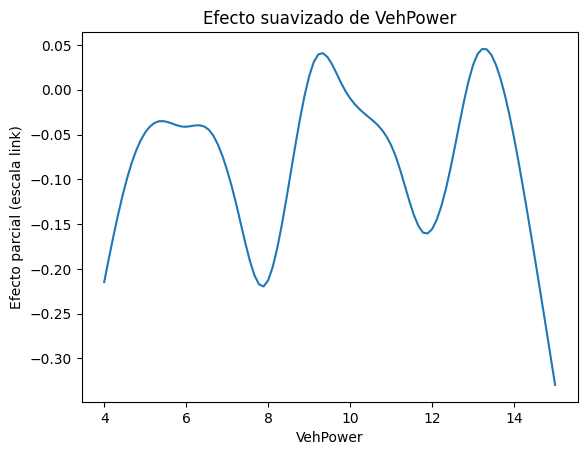

In [283]:
XX = Pgam.generate_X_grid(term=0)
pdep = Pgam.partial_dependence(term=0, X=XX)

plt.figure()
plt.plot(XX[:, 0], pdep)
plt.xlabel("VehPower")
plt.ylabel("Efecto parcial (escala link)")
plt.title("Efecto suavizado de VehPower")
plt.show()


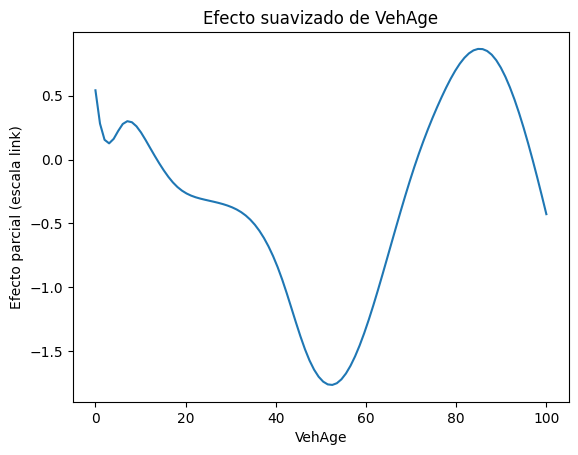

In [284]:
XX = Pgam.generate_X_grid(term=1)
pdep = Pgam.partial_dependence(term=1, X=XX)

plt.figure()
plt.plot(XX[:, 1], pdep)
plt.xlabel("VehAge")
plt.ylabel("Efecto parcial (escala link)")
plt.title("Efecto suavizado de VehAge")
plt.show()


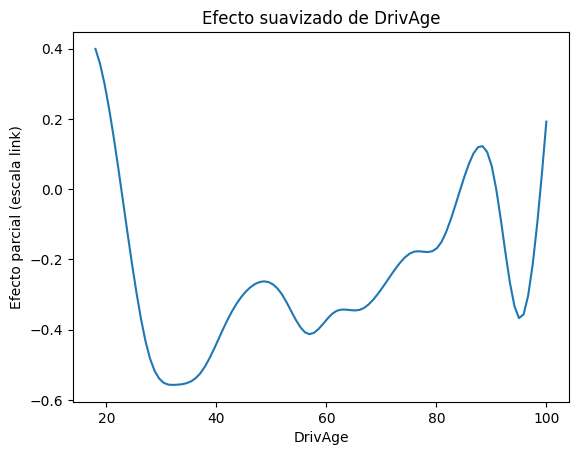

In [285]:
XX = Pgam.generate_X_grid(term=2)
pdep = Pgam.partial_dependence(term=2, X=XX)

plt.figure()
plt.plot(XX[:, 2], pdep)
plt.xlabel("DrivAge")
plt.ylabel("Efecto parcial (escala link)")
plt.title("Efecto suavizado de DrivAge")
plt.show()


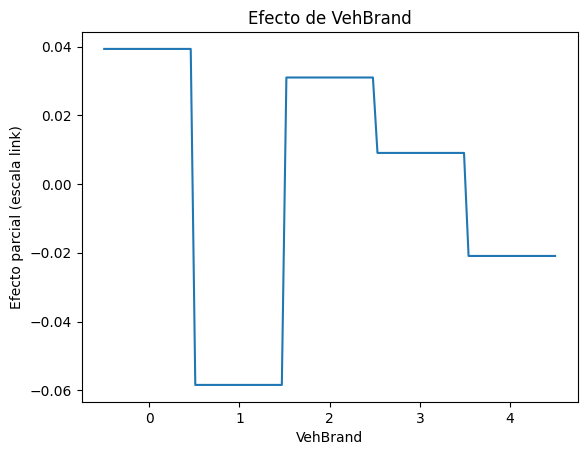

In [286]:
XX = Pgam.generate_X_grid(term=3)
pdep = Pgam.partial_dependence(term=3, X=XX)

plt.figure()
plt.plot(XX[:, 3], pdep)
plt.xlabel("VehBrand")
plt.ylabel("Efecto parcial (escala link)")
plt.title("Efecto de VehBrand")
plt.show()


In [288]:
cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    sev[c] = sev[c].astype("category").cat.codes

for n in num_vars:
    sev[n] = pd.to_numeric(sev[n], errors="coerce")

# matriz X en el orden correcto
X2 = sev[num_vars + cat_vars].values
y = sev["ClaimAmount"].values

Ggam = pygam.GammaGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4)            # Area
).fit(X2, y)

print(Ggam.summary())

GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     46.3413
Link Function:                          LogLink Log Likelihood:                               -246559.6559
Number of Samples:                        26444 AIC:                                           493213.9945
                                                AICc:                                          493214.1679
                                                GCV:                                                1.3486
                                                Scale:                                              7.8892
                                                Pseudo R-Squared:                                   0.0208
Feature Function                  Lam

AIC peor modelo que GLM IG

In [289]:
cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    sev[c] = sev[c].astype("category").cat.codes

for n in num_vars:
    sev[n] = pd.to_numeric(sev[n], errors="coerce")

# matriz X en el orden correcto
X2 = sev[num_vars + cat_vars].values
y = sev["ClaimAmount"].values

IGgam = pygam.InvGaussGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4)            # Area
).fit(X2, y)

print(IGgam.summary())

InvGaussGAM                                                                                               
=============================================== ==========================================================
Distribution:                      InvGaussDist Effective DoF:                                     20.5519
Link Function:                          LogLink Log Likelihood:                               -369119.1263
Number of Samples:                        26444 AIC:                                           738281.3562
                                                AICc:                                           738281.393
                                                GCV:                                                0.0023
                                                Scale:                                              0.0044
                                                Pseudo R-Squared:                                   0.0043
Feature Function                  Lam

AIC malo

Probamos si mejora sacando s0 y s1

In [290]:
cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["DrivAge"]

# asegurar tipos
for c in cat_vars:
    sev[c] = sev[c].astype("category").cat.codes

for n in num_vars:
    sev[n] = pd.to_numeric(sev[n], errors="coerce")

# matriz X en el orden correcto
X2 = sev[num_vars + cat_vars].values
y = sev["ClaimAmount"].values

G2gam = pygam.GammaGAM(
    s(0) +          # DrivAge
    f(1) +          # VehBrand_grp
    f(2)            # Area
).fit(X2, y)

print(G2gam.summary())


GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     26.1774
Link Function:                          LogLink Log Likelihood:                               -247074.7797
Number of Samples:                        26444 AIC:                                           494203.9143
                                                AICc:                                          494203.9723
                                                GCV:                                                1.3531
                                                Scale:                                              8.1051
                                                Pseudo R-Squared:                                   0.0155
Feature Function                  Lam

Empeora

Modelos:

In [293]:
cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    freq[c] = freq[c].astype("category").cat.codes

for n in num_vars:
    freq[n] = pd.to_numeric(freq[n], errors="coerce")

# matriz X en el orden correcto
X = freq[num_vars + cat_vars].values
y = freq["ClaimNb"].values

Pgam = PoissonGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4)            # Area
).fit(X, y, weights=freq["Exposure"].values)

cat_vars = ["VehBrand_grp", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

# asegurar tipos
for c in cat_vars:
    sev[c] = sev[c].astype("category").cat.codes

for n in num_vars:
    sev[n] = pd.to_numeric(sev[n], errors="coerce")

# matriz X en el orden correcto
X2 = sev[num_vars + cat_vars].values
y2 = sev["ClaimAmount"].values

Ggam = pygam.GammaGAM(
    s(0) +          # VehPower
    s(1) +          # VehAge
    s(2) +          # DrivAge
    f(3) +          # VehBrand_grp
    f(4)            # Area
).fit(X2, y2)

In [294]:
mu = Pgam.predict_mu(X)
resid_dev = Pgam.deviance_residuals(X, y)
deviance = np.sum(resid_dev**2)
df_resid = X.shape[0] - Pgam.statistics_['edof']
dispersion = deviance / df_resid
print("Deviance:", deviance, "df_resid:", df_resid, "Dispersion:", dispersion)

Deviance: 216259.74914037596 df_resid: 677966.695781859 Dispersion: 0.3189828504643231


In [295]:
freq['pred_rate'] = Pgam.predict(X)  # rate por unidad de exposure si ajustaste con weights
freq['pred_claims'] = freq['pred_rate'] * freq['Exposure']

# agrupar por Area, VehBrand_grp y comparar
print(freq.groupby('VehAge')[['ClaimNb','pred_claims']].sum())
print(freq.groupby('DrivAge')[['ClaimNb','pred_claims']].sum())
print(freq.groupby('Area')[['ClaimNb','pred_claims']].sum())
print(freq.groupby('VehPower')[['ClaimNb','pred_claims']].sum())

        ClaimNb  pred_claims
VehAge                      
0          5205       1506.2
1          2931       2284.8
2          2768       1841.6
3          2320       1584.2
4          2282       1507.1
...         ...          ...
83            0     0.067584
84            1      0.12513
85            0      0.12139
99            1       0.5446
100           0      0.56892

[78 rows x 2 columns]
         ClaimNb  pred_claims
DrivAge                      
18            65       27.373
19           243       112.63
20           335        169.6
21           353       195.34
22           430       218.58
...          ...          ...
96             0      0.78921
97             0       0.5094
98             0      0.29155
99             8       4.7407
100            0      0.18944

[83 rows x 2 columns]
      ClaimNb  pred_claims
Area                      
0        5056       3527.2
1        3800       2552.3
2        9875       6555.0
3        8390       5207.8
4        7804       4704.

Tiende a subestimar a simple vista

In [296]:
freq['pred_rate_sev'] = Ggam.predict(X)
freq[["pred_freq", "pred_rate", "pred_sev",'pred_rate_sev']].head()

,pred_freq,pred_rate,pred_sev,pred_rate_sev
0,0.14162,0.092517,1935.2,1794.0
1,0.14162,0.092517,1935.2,1794.0
2,0.11,0.060848,1782.2,2083.8
3,0.10704,0.086937,1837.5,1787.9
4,0.10704,0.086937,1837.5,1787.9


Predicciones mas conservadoras

GRADIENT BOOSTING

In [297]:
cat_vars = ["VehBrand_grp", "VehGas", "Area"]
num_vars = ["VehPower", "VehAge", "DrivAge"]

features = num_vars + cat_vars

In [298]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_vars),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_vars)
    ]
)

In [299]:
gb_freq = HistGradientBoostingRegressor(
    loss="poisson",
    learning_rate=0.05,
    max_depth=4,
    max_iter=300,
    random_state=42
)

In [300]:
pipe_freq = Pipeline(
    steps=[
        ("prep", preprocess),
        ("gb", gb_freq)
    ]
)

In [301]:
X = freq[features]
y = freq["ClaimNb"]

pipe_freq.fit(
    X,
    y,
    gb__sample_weight=freq["Exposure"]
)

,steps,"[('prep', ...), ('gb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [302]:
freq["pred_claims_gb"] = pipe_freq.predict(X)

In [303]:
gb_sev = HistGradientBoostingRegressor(
    loss="gamma",
    learning_rate=0.05,
    max_depth=4,
    max_iter=300,
    random_state=42
)

In [306]:
pipe_sev = Pipeline(
    steps=[
        ("prep", preprocess),
        ("gb", gb_sev)
    ]
)

In [307]:
pipe_sev.fit(
    sev[features],
    sev["ClaimAmount"] / sev["ClaimNb"]
)

sev["pred_sev_gb"] = pipe_sev.predict(sev[features])

Colas mas pesadas

In [308]:
print(sev["pred_sev"].describe(), sev[["pred_sev_gb"]].describe())

count   2.6432e+04
mean        1867.5
std         169.63
min         1174.8
25%         1754.9
50%         1868.1
75%         1984.9
max         2511.0
Name: pred_sev, dtype: float64        pred_sev_gb
count   2.6444e+04
mean        1722.2
std         84.233
min         1297.4
25%         1693.8
50%         1723.2
75%         1740.2
max         2479.7


Parecidos

In [309]:
print(freq["pred_freq"].describe(), freq[["pred_claims_gb"]].describe())

count   6.7801e+05
mean       0.10575
std       0.025003
min       0.053467
25%       0.086831
50%        0.10347
75%        0.12205
max        0.18629
Name: pred_freq, dtype: float64        pred_claims_gb
count      6.7801e+05
mean         0.066069
std          0.024979
min          0.011413
25%          0.052592
50%          0.061703
75%           0.07346
max           0.35592


Mayor parte no presentaria Claim

In [310]:
print(freq.groupby("Area")[["ClaimNb", "pred_claims_gb"]].sum())
print(freq.groupby("VehAge")[["ClaimNb", "pred_claims_gb"]].sum())
print(freq.groupby("VehBrand_grp")[["ClaimNb", "pred_claims_gb"]].sum())
print(freq.groupby("DrivAge")[["ClaimNb", "pred_claims_gb"]].sum())
print(freq.groupby("VehPower")[["ClaimNb", "pred_claims_gb"]].sum())

      ClaimNb  pred_claims_gb
Area                         
0        5056          6252.1
1        3800          4564.2
2        9875      1.2034e+04
3        8390      1.0374e+04
4        7804      1.0211e+04
5        1131          1360.9
        ClaimNb  pred_claims_gb
VehAge                         
0          5205          6039.1
1          2931          4172.8
2          2768          3639.3
3          2320          3162.3
4          2282          2940.4
...         ...             ...
83            0         0.14929
84            1        0.074644
85            0        0.073144
99            1           1.299
100           0          1.2125

[78 rows x 2 columns]
              ClaimNb  pred_claims_gb
VehBrand_grp                         
0                8639      1.0534e+04
1               16091      2.0304e+04
2                8552      1.0441e+04
3                1312          1666.1
4                1462          1850.6
         ClaimNb  pred_claims_gb
DrivAge               

Mucho mas preciso en cantidad de reclamos (ClaimNb)

In [311]:
freq["pure_premium_gb"] = freq["pred_claims_gb"] * sev["pred_sev_gb"].mean()

In [313]:
print(freq["pure_premium_gb"].describe(), freq[["prima_pura"]].describe())

count   6.7801e+05
mean        113.79
std          43.02
min         19.656
25%         90.576
50%         106.27
75%         126.52
max         612.97
Name: pure_premium_gb, dtype: float64        prima_pura
count  6.7801e+05
mean       199.84
std         56.37
min        88.066
25%         155.7
50%        193.22
75%        234.26
max         374.2


GB es menos severo en la media y extiende mas las colas. GLM concentra la severidad

In [ ]:
print(freq[["pred_claims_gb", "pred_freq", "pure_premium_gb", "prima_pura"]])

print(sev[["pred_sev_gb","pred_sev"]])


        pred_claims_gb  pred_freq  pure_premium_gb  prima_pura
0              0.19966    0.16566           387.82       320.6
1              0.19966    0.16566           387.82       320.6
2             0.060927     0.1153           118.34      232.41
3             0.082201    0.10859           159.67      243.99
4             0.082201    0.10859           159.67      243.99
...                ...        ...              ...         ...
679508         0.14729    0.17269           286.09      321.99
679509         0.16236    0.17269           315.37      321.99
679510        0.072016    0.15363           139.88      282.06
679511         0.13517    0.11127           262.55       260.5
679512        0.056385    0.10647           109.52      329.28

[679513 rows x 4 columns]
        pred_sev_gb  pred_sev
66           1678.5    1696.8
93           1941.7    2137.1
199          2031.2    1864.6
205          1678.5    1540.0
206          1678.5    1540.0
...             ...       ...
678974 